# CS 680 Machine Learning Course Project
# Author: Yulin Xue
# Student ID: 20949719

Reference: 

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule

In [ ]:
!pip install -U tensorflow_text
!pip install -q tf-models-official

     |████████████████████████████████| 4.9 MB 14.9 MB/s 
     |████████████████████████████████| 462 kB 83.7 MB/s 
     |████████████████████████████████| 2.2 MB 15.2 MB/s 
     |████████████████████████████████| 636 kB 55.6 MB/s 
     |████████████████████████████████| 1.2 MB 57.2 MB/s 
     |████████████████████████████████| 99 kB 10.9 MB/s 
     |████████████████████████████████| 352 kB 67.3 MB/s 
     |████████████████████████████████| 47.8 MB 1.2 MB/s 
     |████████████████████████████████| 90 kB 11.0 MB/s 
     |████████████████████████████████| 237 kB 71.2 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import re

In [ ]:
train = pd.read_csv("train.csv")
test =  pd.read_csv("test.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'diaster non-related vs diaster related')]

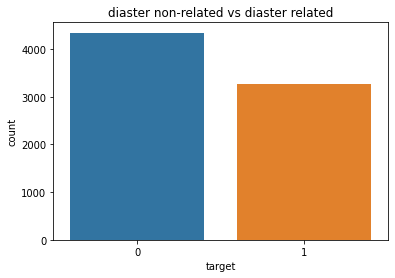

In [ ]:
# Data Analysis
sns.countplot(train["target"]).set(title='diaster non-related vs diaster related')

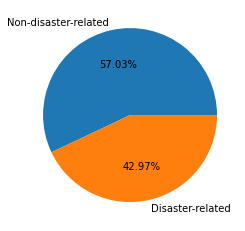

In [ ]:
data = [len(train[train["target"] == 0]), len(train[train["target"] == 1])]
labels = ['Non-disaster-related', 'Disaster-related']
plt.pie(data, labels=labels, autopct = '%.2f%%')
plt.show()

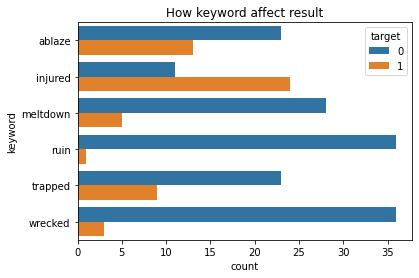

In [ ]:
# Create a small trainging set for better look graph
train_small = train[(train['keyword']=='ablaze') | (train['keyword']=='injured') | 
                    (train['keyword']=='meltdown') | (train['keyword']=='ruin') |
                    (train['keyword']=='trapped') | (train['keyword']=='wrecked')]

ax = sns.countplot(y="keyword", hue="target", data=train_small).set(title='How keyword affect result')

In [ ]:
# Data Cleaning
for i in range(len(train)):
  train['text'][i] = re.sub(r'https*\S+', ' ', train['text'][i]) # remove links
  train['text'][i] = re.sub(r'http*\S+', ' ', train['text'][i])
  train['text'][i] = re.sub(r'&amp;', '', train['text'][i])
  train['text'][i] = re.sub(r'[^a-zA-Z0-9\s]', '', train['text'][i])

for i in range(len(test)):
  test['text'][i] = re.sub(r'https*\S+', ' ', test['text'][i]) # remove links
  test['text'][i] = re.sub(r'http*\S+', ' ', test['text'][i])
  test['text'][i] = re.sub(r'&amp;', '', test['text'][i])
  test['text'][i] = re.sub(r'[^a-zA-Z0-9\s]', '', test['text'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

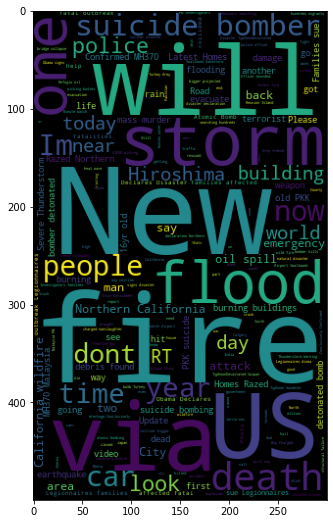

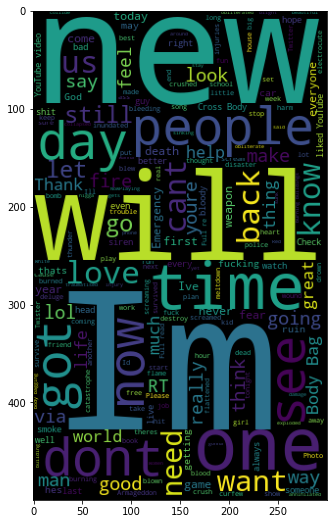

In [ ]:
from wordcloud import WordCloud

token = '  '.join(list(train[train['target']==1]['text']))
token = WordCloud(width=300, height=500).generate(token)
plt.figure(figsize=(9, 9))
plt.imshow(token)
plt.show()

token = '  '.join(list(train[train['target']==0]['text']))
token = WordCloud(width=300, height=500).generate(token)
plt.figure(figsize=(9, 9))
plt.imshow(token)
plt.show()

[Text(0.5, 1.0, 'Length of word in each tweets')]

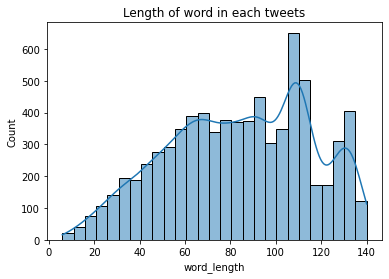

In [ ]:
train['word_length'] = train['text'].apply(lambda x: len(str(x)))
sns.histplot(data=train, x="word_length", kde=True).set(title='Length of word in each tweets')

[Text(0.5, 1.0, 'Missing data on training set')]

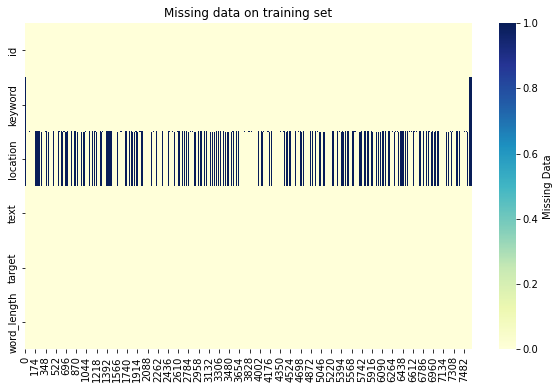

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(train.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'}).set(title='Missing data on training set')

In [ ]:
print(len(train[train["location"].isna()]) / len(train))
print(len(train[train["keyword"].isna()]) / len(train))

0.33272034677525286
0.008012610009194798


<Figure size 720x432 with 0 Axes>

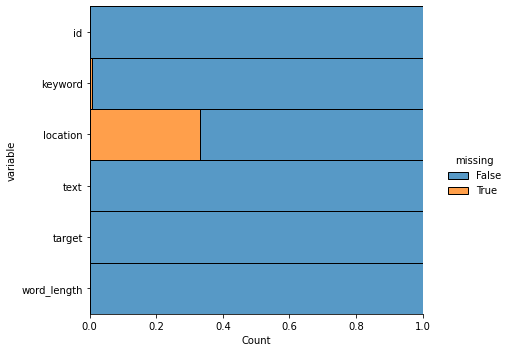

In [ ]:
plt.figure(figsize=(10,6))
sns.displot(
    data=train.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

In [ ]:
from sklearn.model_selection import train_test_split
# Stratify make the balance of training and testing set
X_train, X_valid, y_train, y_valid = train_test_split(train['text'], train['target'], test_size=0.2, stratify=train['target'])

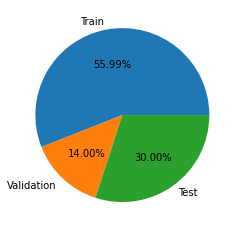

In [ ]:
data = [len(X_train), len(X_valid), len(test)]
labels = ['Train', 'Validation', 'Test']
plt.pie(data, labels=labels, autopct = '%.2f%%')
plt.show()

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="BERT")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True, name="encoder")

In [ ]:
def build_model():
  # Bert Layer
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)

  # Neural network layers
  layer = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
  layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer)

  return tf.keras.Model(text_input, layer)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

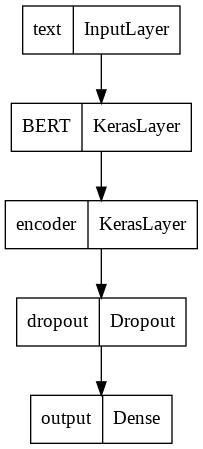

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), epochs=1, batch_size=32)

191/191 [==============================] - 190s 904ms/step - loss: 0.4392 - binary_accuracy: 0.8071 - false_negatives: 726.0000 - val_loss: 0.3753 - val_binary_accuracy: 0.8450 - val_false_negatives: 164.0000


[Text(0.5, 1.0, 'Confusion Matrix of Validation dataset')]

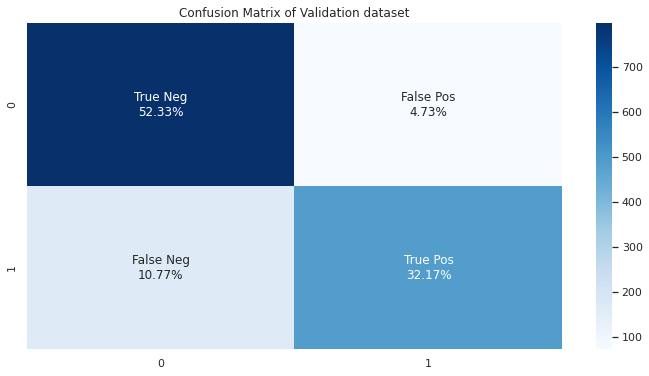

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_valid = model.predict(X_valid)
threshold = 0.5
y_pred_valid = np.where(y_pred_valid[:,] > threshold, 1, 0)
cf_matrix = confusion_matrix(y_valid, y_pred_valid)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(12,6)})
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues').set(title="Confusion Matrix of Validation dataset")

[Text(0.5, 1.0, 'Confusion Matrix of Validation dataset')]

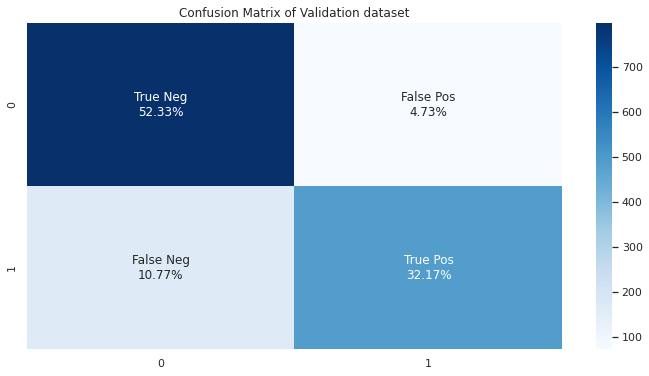

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc = {'figure.figsize':(12,6)})
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues').set(title="Confusion Matrix of Validation dataset")

dict_keys(['loss', 'binary_accuracy', 'false_negatives', 'val_loss', 'val_binary_accuracy', 'val_false_negatives'])


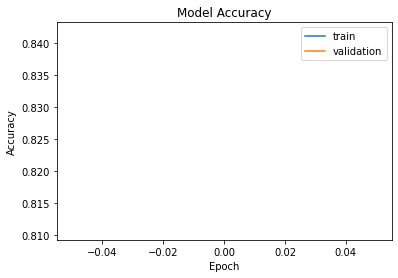

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Make prediction for the testing set
# Generate the "submission.csv" file which can be upload to Kaggle competition
probs = model.predict(test["text"]) 
threshold = 0.5
preds = np.where(probs[:,] > threshold, 1, 0)
submission=pd.read_csv('sample_submission.csv')
submission["target"]=preds
submission.to_csv('submission.csv', index=False, header=True)